In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc, accuracy_score, roc_curve, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# List of all the lineages we will be making dataframes for - some of the DFs don't have a col named depmapid but have depmapids, will require some cleaning
lineages = ["kidney", "breast", "blood", "liver", "urinary_tract", "colorectal", "ovary", "pancreas"]
lineage_df_dict = {}

# List of all the feature dataframes we are going to read into the lineage dataframes
features = ["effect", "dependency", "expression", "gene_cn"]
feature_df_dict = {}

sample_info_df = pd.read_csv('data/sample_info.csv')

folder_path = "data/"

for file_name in os.listdir(folder_path):
    for feature in features:
        if file_name.endswith('.csv') and feature in file_name:
            file_path = os.path.join(folder_path, file_name)
            feature_df_dict[feature] = pd.read_csv(file_path)
            feature_df_dict[feature].columns = [column.split(' ')[0] for column in feature_df_dict[feature].columns]
            feature_df_dict[feature].rename(columns={feature_df_dict[feature].columns[0]: "DepMap_ID"}, inplace=True)
            feature_df_dict[feature] = pd.merge(feature_df_dict[feature], sample_info_df[['DepMap_ID', 'lineage']], on='DepMap_ID', how='left')
            feature_df_dict[feature].drop("DepMap_ID", axis=1, inplace=True)
            feature_df_dict[feature] = feature_df_dict[feature].pivot_table(index='lineage', aggfunc='mean')

for feature in features:
    for lineage in lineages:
        temp_df = feature_df_dict[feature].loc[feature_df_dict[feature].index == lineage].transpose()
        temp_df.index.name = 'gene'
        if lineage in lineage_df_dict:
            temp_df.rename(columns={lineage : feature}, inplace=True)
            lineage_df_dict[lineage] = pd.merge(lineage_df_dict[lineage], temp_df, on="gene", how="outer").dropna()
        else:
            lineage_df_dict[lineage] = pd.DataFrame({feature: temp_df[lineage]}, index=temp_df.index)
            lineage_df_dict[lineage].index.name = 'gene'
            lineage_df_dict[lineage].reset_index(inplace=True)


training_dfs = {}
training_lineages = {"kidney" : "kidney", 
                     "breast" : "breast", 
                     "leukemia" : "blood", 
                     "liver" : "liver", 
                     "bladder" : "urinary_tract",
                     "colon" : "colorectal", 
                     "ovarian" : "ovary", 
                     "pancreatic" : "pancreas"}
for k, v in training_lineages.items():
    # get the df from the training set
    df = pd.read_csv(f"training_sets_genes/{k}_training_genes_set.csv")
    df = df.merge(lineage_df_dict[v], on="gene", how='left').fillna(0)
    
    # drop all training genes from the prediction set
    lineage_df_dict[v] = pd.merge(lineage_df_dict[v], df, indicator=True, how='left', on=list(lineage_df_dict[v].columns)).query('_merge == "left_only"').drop('_merge', axis=1)
    lineage_df_dict[v].drop(columns=['label'], inplace=True)
    df.set_index('gene', inplace=True)
    lineage_df_dict[v].set_index('gene', inplace=True)
    
    # split into 10 samples for 50-50 pos neg split
    samples = []
    for negatives in np.array_split(df[df['label'] == 'negative'], 10):
        samples.append(pd.concat([df[df['label'] == "positive"], negatives]))
    
    training_dfs[k] = samples


rev_training_lineages = {value: key for key, value in training_lineages.items()}

In [45]:
feature_columns = [ 'effect', 'dependency', 'expression', 'gene_cn']
target_column = 'label'

scaler_df = dict()

# Function to preprocess a dataframe
def preprocess_df(key, df):
    # Extract features and target
    X = df[feature_columns].values
    y = df[target_column].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling (standardization)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scaler_df[key] = scaler

    return X_train_scaled, X_test_scaled, y_train, y_test

mlp_classifier_df = dict()

# Function to train and evaluate ANN for a given dataframe
def train_and_evaluate_ann(key,df_list):
    # Preprocess the dataframe
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    # Preprocess each dataframe in the list
    for df in df_list:
        X_train, X_test, y_train, y_test = preprocess_df(key, df)
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)

    # Concatenate the preprocessed data
    X_train_all = np.concatenate(X_train_list)
    X_test_all = np.concatenate(X_test_list)
    y_train_all = np.concatenate(y_train_list)
    y_test_all = np.concatenate(y_test_list)

    # Create an Artificial Neural Network classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

    # Train the classifier
    mlp_classifier.fit(X_train_all, y_train_all)

    # Predictions
    y_pred = mlp_classifier.predict(X_test_all)

    mlp_classifier_df[key] = mlp_classifier

    # Evaluate accuracy
    accuracy = accuracy_score(y_test_all, y_pred)
    print("Accuracy for {}: {:.2f}".format(key, accuracy))

# Loop through each dataframe in the training_dfs dictionary and train/evaluate the ANN
for key, df_list in training_dfs.items():
    print("Training and evaluating ANN for", key)
    train_and_evaluate_ann(key, df_list)

# Swap keys and values
swapped_lineages = {value: key for key, value in training_lineages.items()}

ann_prediction = dict()

for key, df in lineage_df_dict.items():
    scaler = scaler_df[swapped_lineages[key]]
    genes = df.index
    X = df[feature_columns].values
    X_new_scaled = scaler.transform(X)
    
    # Use the trained ANN model to make predictions on the new data
    y_new_pred = mlp_classifier_df[swapped_lineages[key]].predict(X_new_scaled)

    ann_prediction[key] = pd.DataFrame({'gene': genes, 'prediction': y_new_pred})
    ann_prediction[key].set_index('gene', inplace=True)

ann_prediction

# Plots




Training and evaluating ANN for kidney
Accuracy for kidney: 0.62
Training and evaluating ANN for breast
Accuracy for breast: 0.57
Training and evaluating ANN for leukemia
Accuracy for leukemia: 0.58
Training and evaluating ANN for liver


/Users/pranavphadke/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for liver: 0.58
Training and evaluating ANN for bladder


/Users/pranavphadke/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for bladder: 0.47
Training and evaluating ANN for colon


/Users/pranavphadke/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for colon: 0.41
Training and evaluating ANN for ovarian


/Users/pranavphadke/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for ovarian: 0.46
Training and evaluating ANN for pancreatic
Accuracy for pancreatic: 0.55


/Users/pranavphadke/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'kidney':         prediction
 gene              
 A1BG      positive
 A1CF      positive
 A2M       positive
 A2ML1     positive
 A3GALT2   positive
 ...            ...
 ZYG11A    positive
 ZYG11B    positive
 ZYX       positive
 ZZEF1     positive
 ZZZ3      positive
 
 [17076 rows x 1 columns],
 'breast':         prediction
 gene              
 A2M       negative
 A2ML1     negative
 A3GALT2   positive
 A4GALT    negative
 A4GNT     negative
 ...            ...
 ZYG11A    negative
 ZYG11B    negative
 ZYX       negative
 ZZEF1     negative
 ZZZ3      negative
 
 [16372 rows x 1 columns],
 'blood':         prediction
 gene              
 A1CF      negative
 A2M       negative
 A2ML1     negative
 A3GALT2   negative
 A4GALT    negative
 ...            ...
 ZXDC      negative
 ZYG11A    negative
 ZYG11B    positive
 ZYX       negative
 ZZEF1     positive
 
 [14870 rows x 1 columns],
 'liver':         prediction
 gene              
 A1BG      positive
 A1CF      positive
 A2M       nega

In [46]:
# for key,v in ann_prediction.items():

#     prediction_counts = v['prediction'].value_counts()

#     # Create a bar plot
#     prediction_counts.plot(kind='bar', color=['blue', 'orange'])
#     plt.title('Distribution of Predictions for ' + key)
#     plt.xlabel('Prediction')
#     plt.ylabel('Count')
#     plt.xticks(rotation=0)
#     plt.show()

In [47]:
CCLE_expression = pd.read_csv("data/CCLE_expression.csv")

In [48]:
# Assuming df is your DataFrame
# Drop the 'Unnamed: 0' column if not needed
CCLE_expression = CCLE_expression.drop(columns=['Unnamed: 0'])

# Transpose the DataFrame
transposed_df = CCLE_expression.T

# Calculate the average expression value for each gene (previously columns)
avg_expression = transposed_df.mean(axis=1)

# Create a new DataFrame with gene names and their corresponding average expression values
new_df = pd.DataFrame({'Average_Expression': avg_expression})

new_df.index = [g.split(' ')[0] for g in new_df.index]

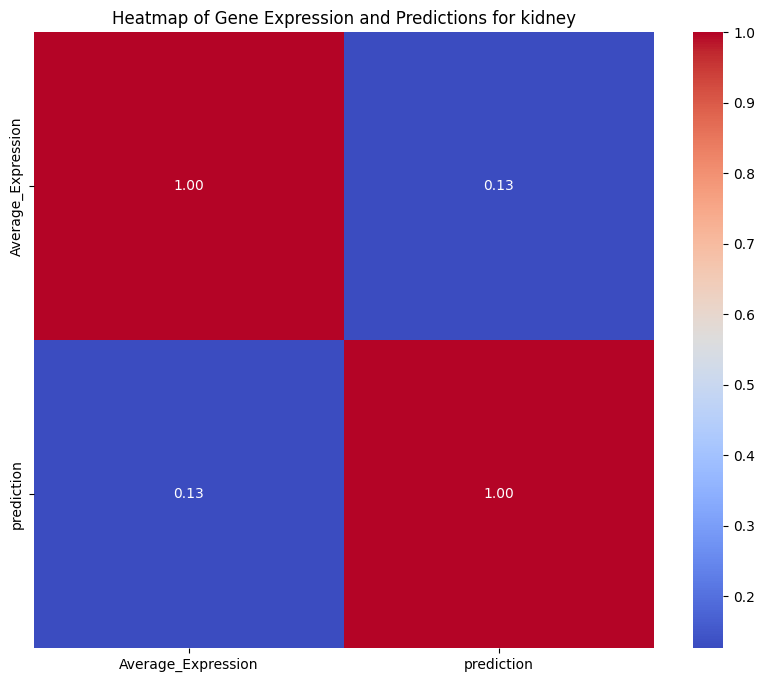

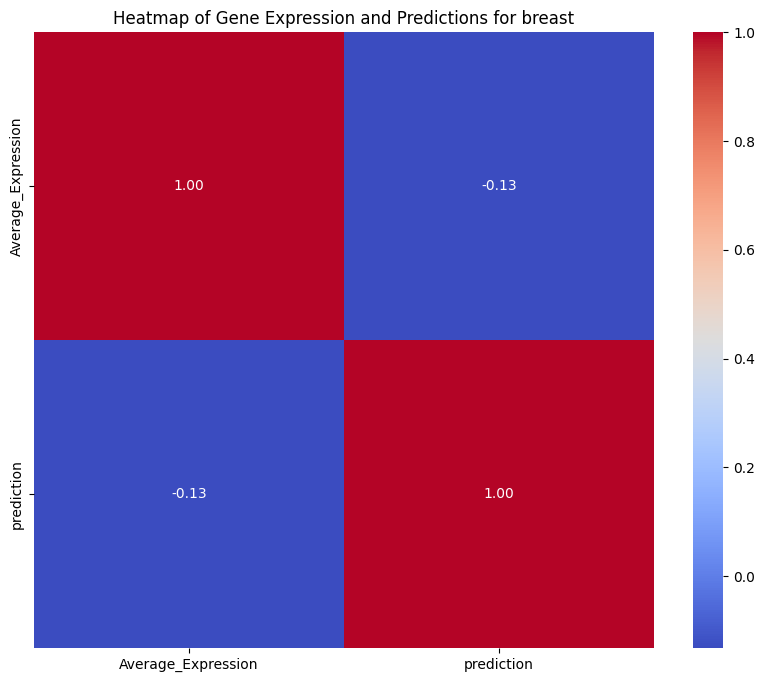

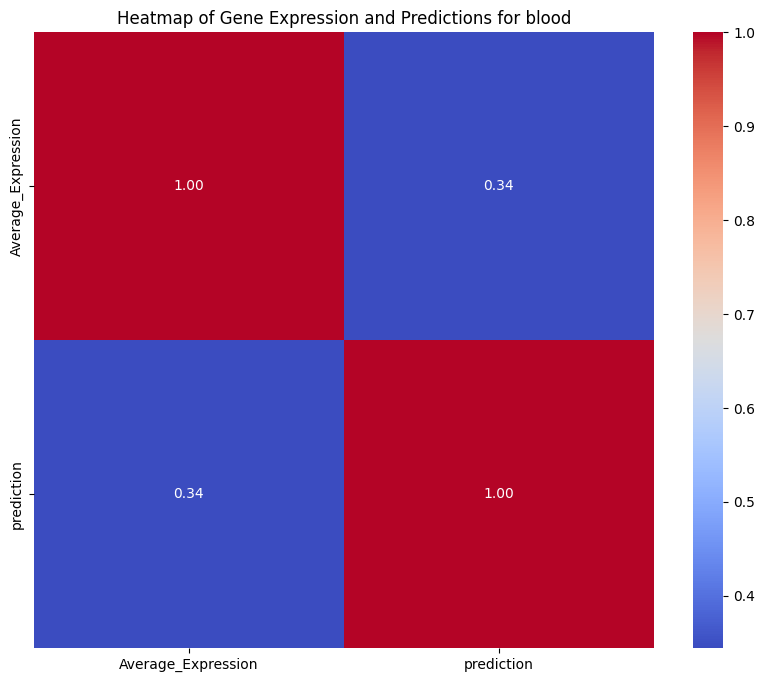

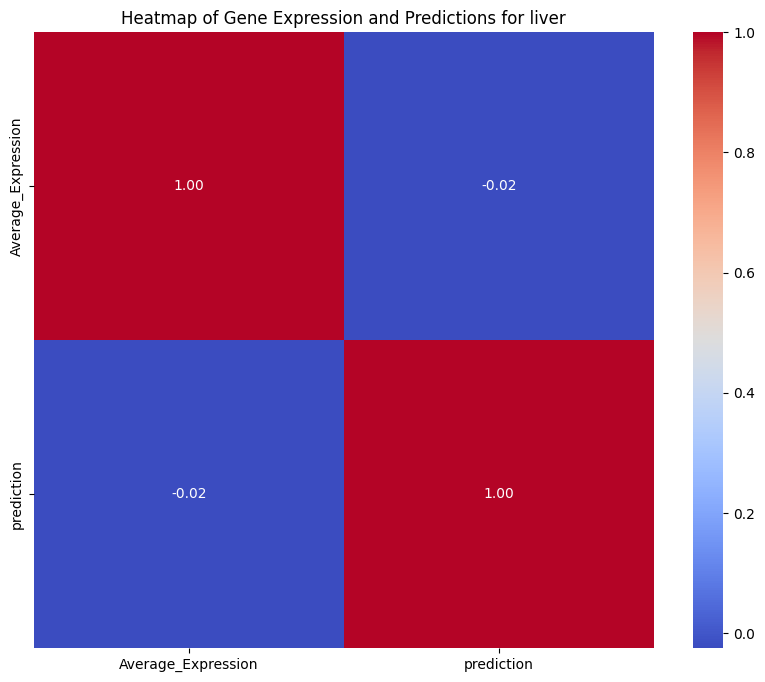

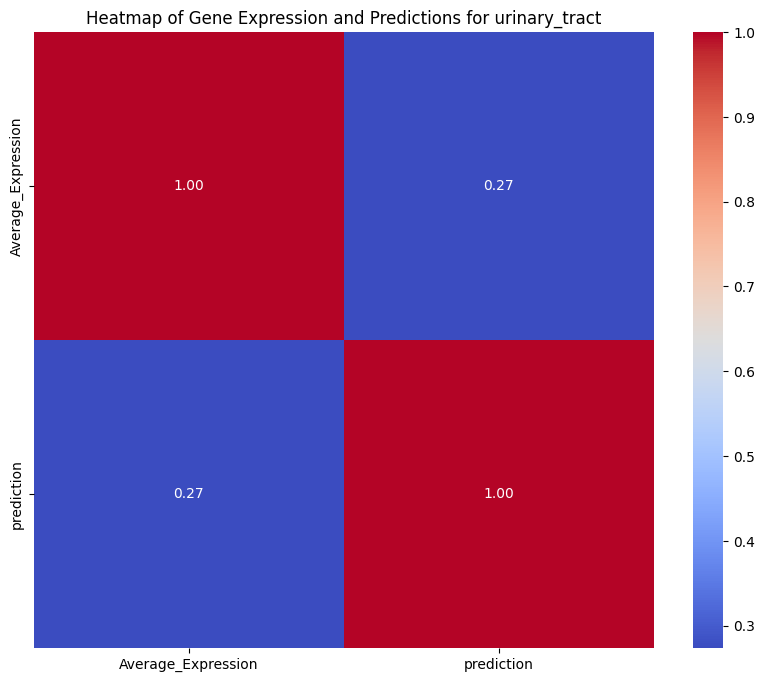

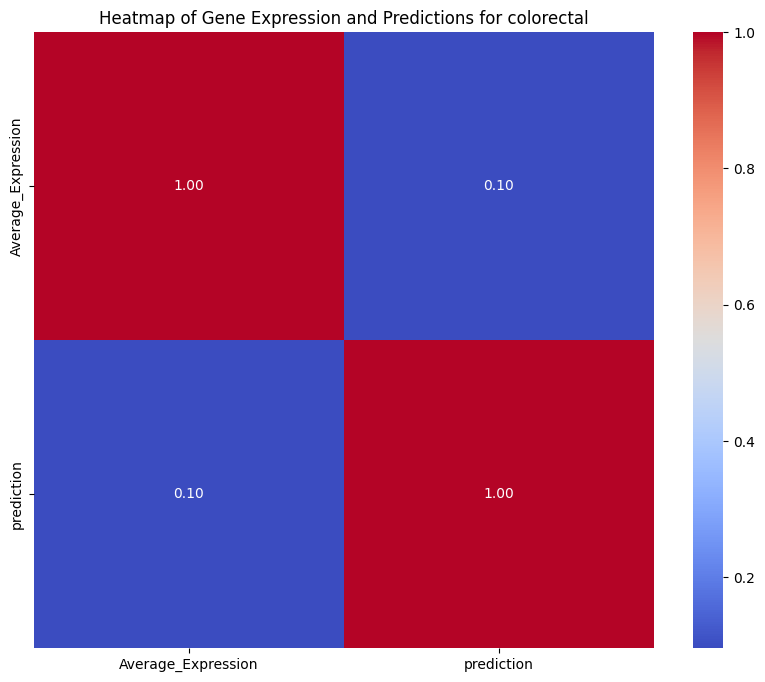

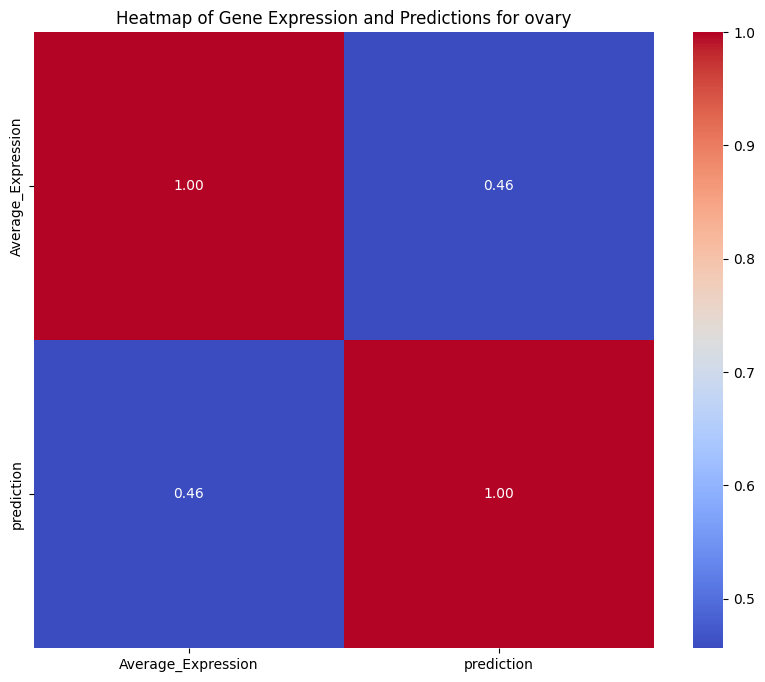

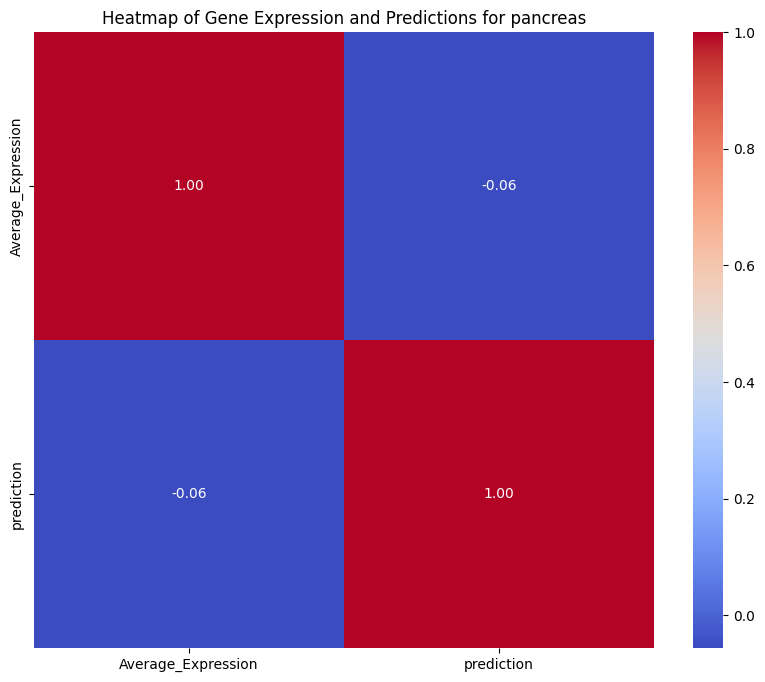

In [51]:
import seaborn as sns

for key,v in ann_prediction.items():
    # Assuming expr_data is a DataFrame containing gene expression data
    # Combine gene expression data with predictions
    v['prediction'] = v['prediction'].map({'positive': 1, 'negative': -1})
    combined_expr = pd.concat([new_df, v['prediction']], axis=1)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(combined_expr.corr(), cmap='coolwarm', annot=True, fmt=".2f")
    plt.title('Heatmap of Gene Expression and Predictions for '+ key)
    plt.show()


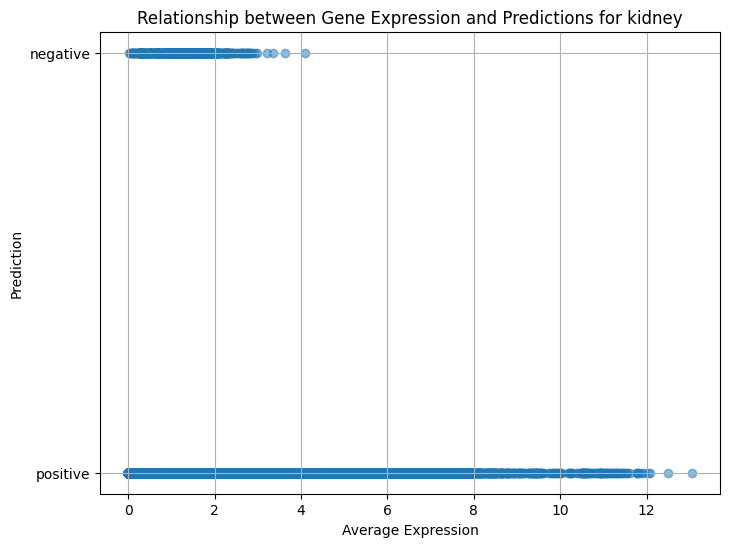

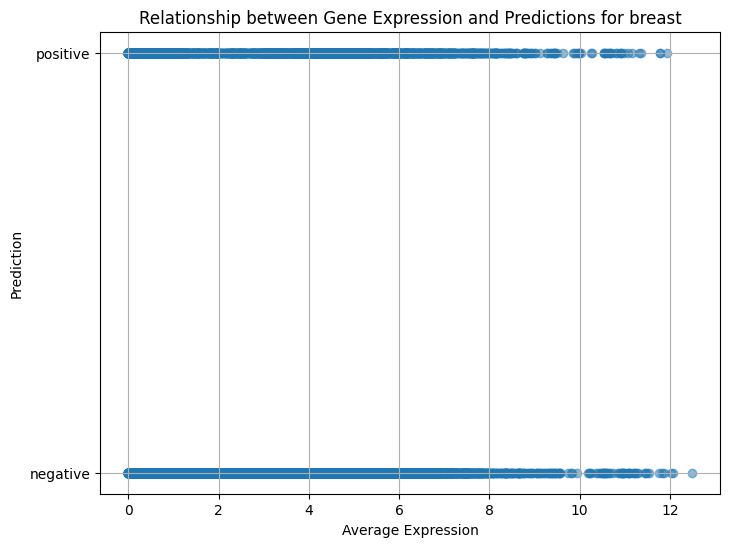

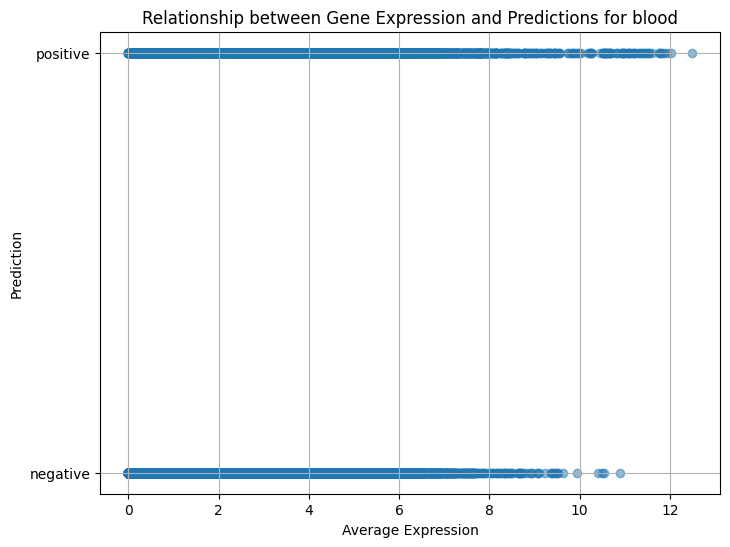

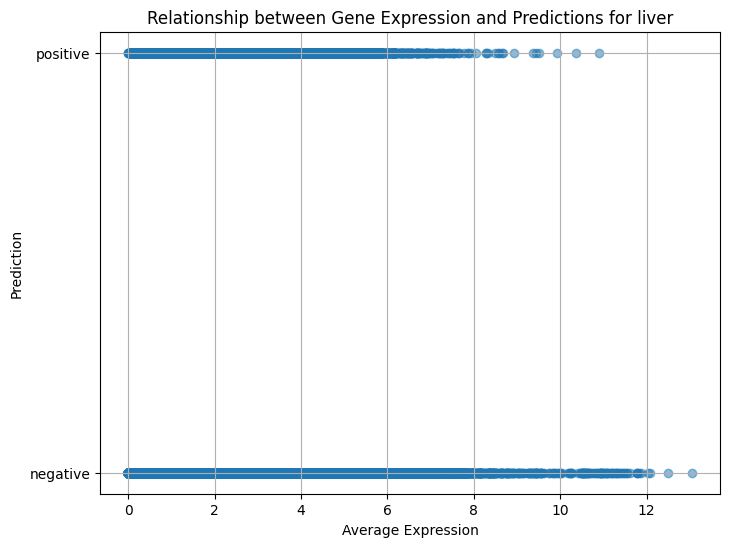

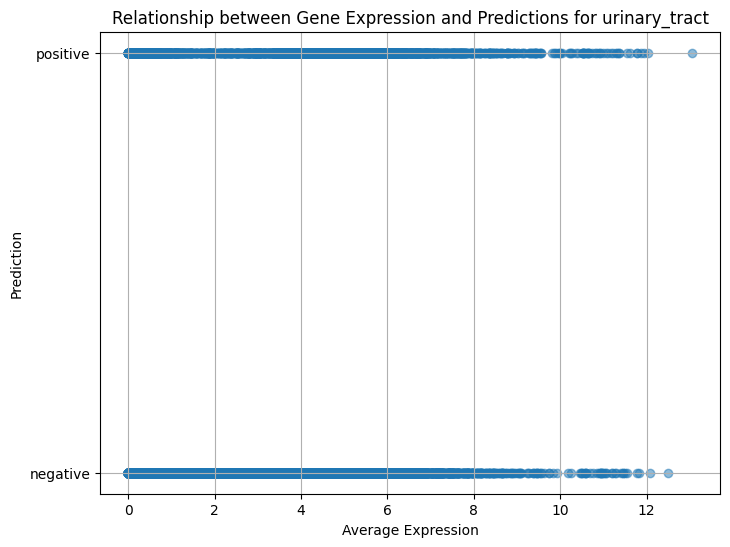

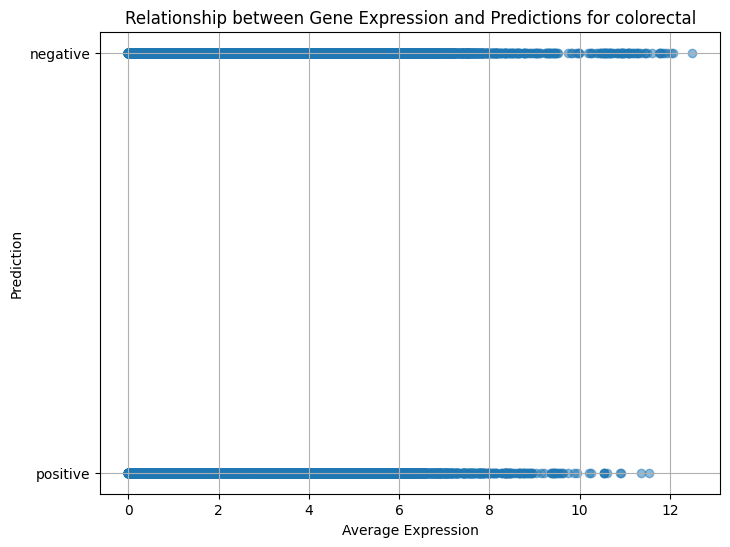

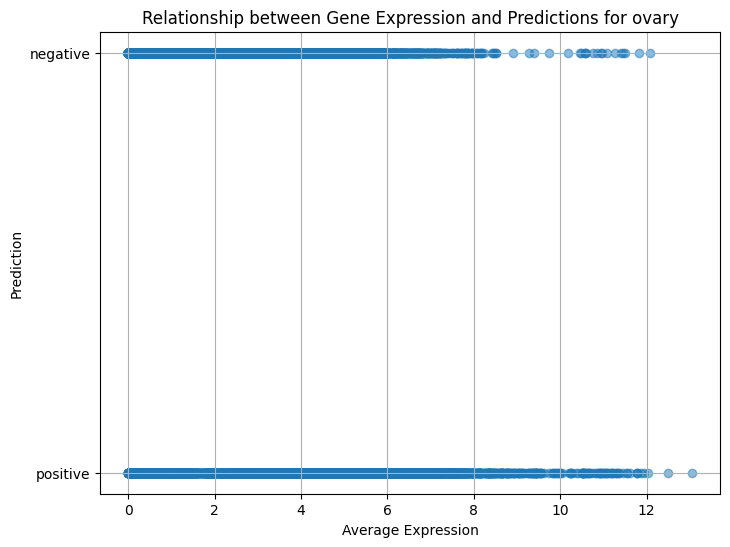

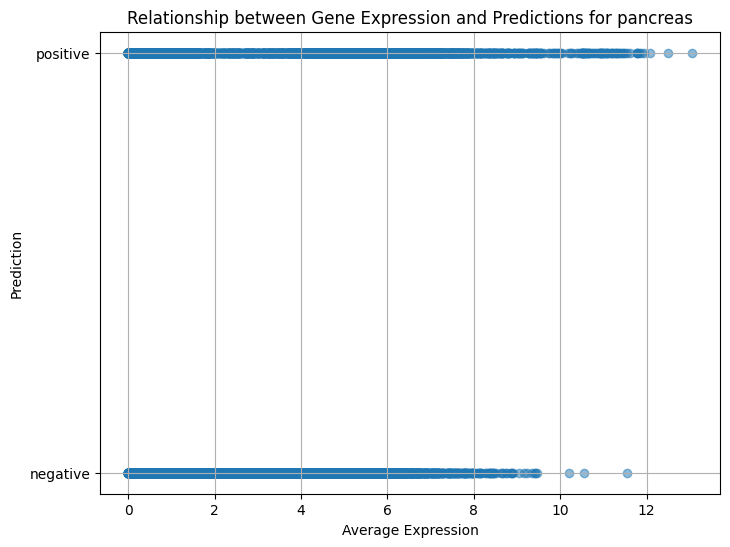

In [50]:
import matplotlib.pyplot as plt

# Assuming avg_expression_df is your DataFrame containing genes and their average expression values
# Assuming prediction_df is your DataFrame containing genes and their prediction values

for key,v in ann_prediction.items():

    # Merge the two DataFrames on the gene column
    merged_df = pd.merge(new_df, v, left_index=True, right_index=True)
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Average_Expression'], merged_df['prediction'], alpha=0.5)
    plt.xlabel('Average Expression')
    plt.ylabel('Prediction')
    plt.title('Relationship between Gene Expression and Predictions for ' + key)
    plt.grid(True)
    plt.show()
